# Import Necessary Libraries

In [4]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [5]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-04-29 14:44:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.1'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-29 14:44:58 (60.2 MB/s) - 'helper_functions.py.1' saved [10246/10246]



In [7]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [8]:
# Walk through each directory
dataset = "/kaggle/input/vm-7-2-1-split/Final/train_set"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/kaggle/input/vm-7-2-1-split/Final/train_set'.
There are 0 directories and 36 images in '/kaggle/input/vm-7-2-1-split/Final/train_set/vm'.
There are 0 directories and 51 images in '/kaggle/input/vm-7-2-1-split/Final/train_set/nonvm'.


In [9]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [12]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

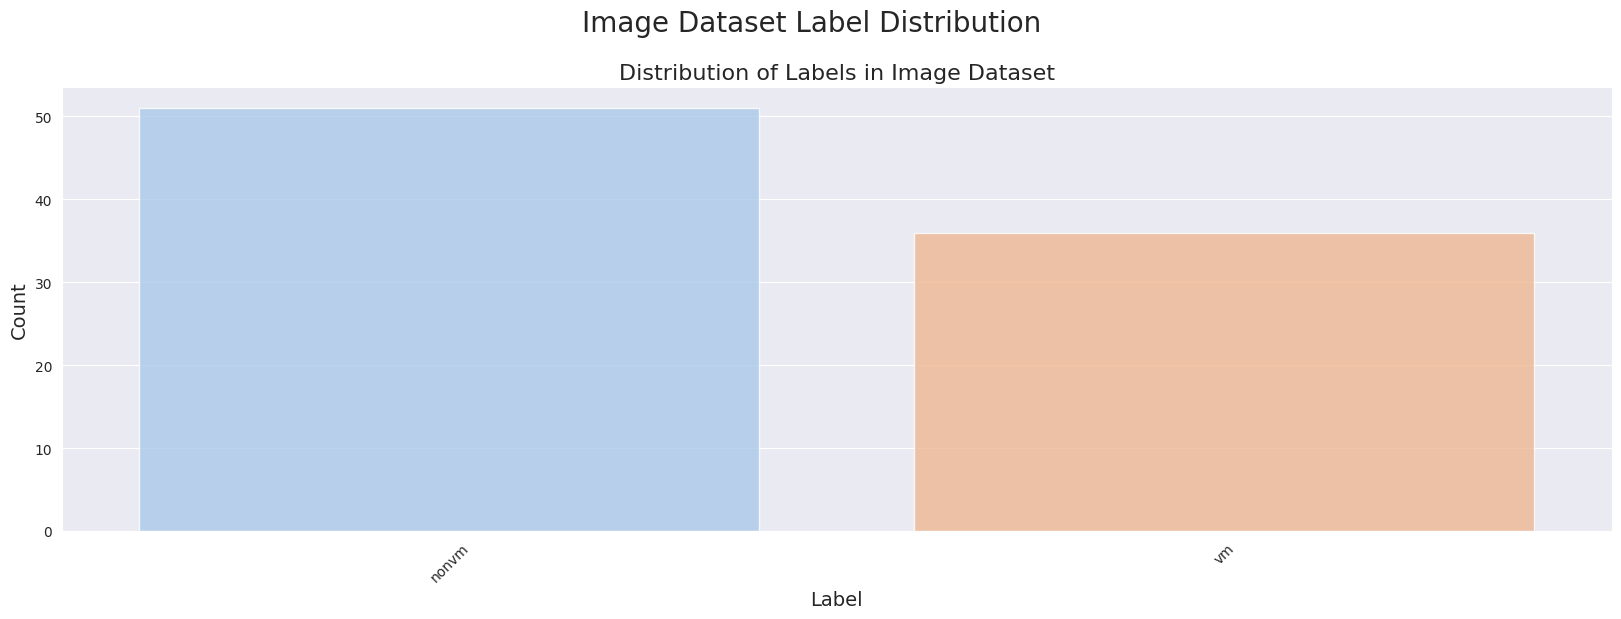

In [13]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

# 🔭Visualizing images from the dataset

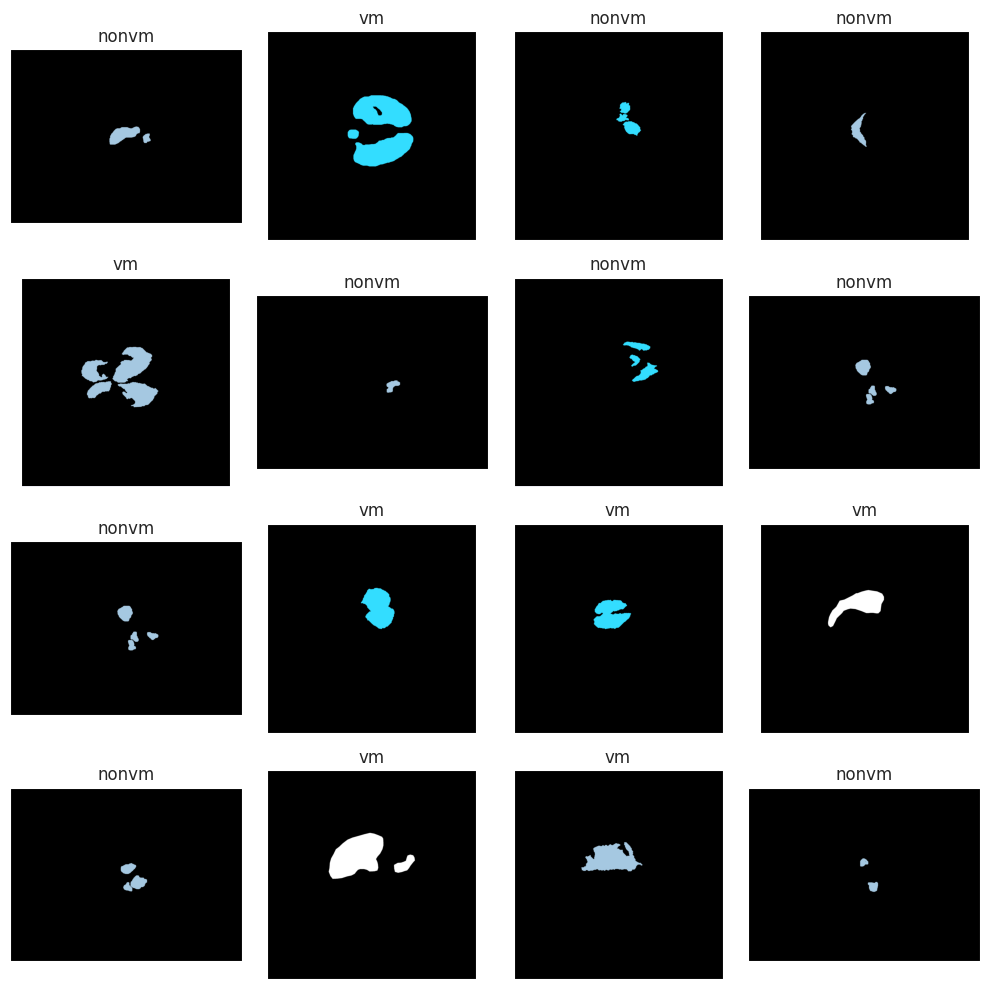

In [14]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [15]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

In [16]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.28, shuffle=True, random_state=42)

In [17]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [18]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 50 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.
Found 25 validated image filenames belonging to 2 classes.


In [20]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [21]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

258076736/258076736 [==============================] - 2s 0us/step


In [22]:
# Create checkpoint callback
checkpoint_path = "vm_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# 🚄Training the model

In [23]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
)

Epoch 1/100


2024-04-29 14:47:37.206564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1714402062.937339     135 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 37s 8s/step - loss: 1.8109 - accuracy: 0.3600 - val_loss: 1.1399 - val_accuracy: 0.4167
Epoch 2/100
2/2 [==============================] - 3s 2s/step - loss: 1.5321 - accuracy: 0.3400 - val_loss: 1.0882 - val_accuracy: 0.4167
Epoch 3/100
2/2 [==============================] - 3s 2s/step - loss: 1.3879 - accuracy: 0.5800 - val_loss: 1.0313 - val_accuracy: 0.4167
Epoch 4/100
2/2 [==============================] - 3s 1s/step - loss: 1.3207 - accuracy: 0.5000 - val_loss: 0.9845 - val_accuracy: 0.4167
Epoch 5/100
2/2 [==============================] - 4s 2s/step - loss: 1.3145 - accuracy: 0.5200 - val_loss: 0.9456 - val_accuracy: 0.3333
Epoch 6/100
2/2 [==============================] - 3s 3s/step - loss: 1.4130 - accuracy: 0.5400 - val_loss: 0.9089 - val_accuracy: 0.3333
Epoch 7/100
2/2 [==============================] - 3s 2s/step - loss: 1.4404 - accuracy: 0.5200 - val_loss: 0.8790 - val_accuracy: 0.2500
Epoch 8/100
2/2 [============================

In [24]:
history.history['accuracy']

[0.36000001430511475,
 0.3400000035762787,
 0.5799999833106995,
 0.5,
 0.5199999809265137,
 0.5400000214576721,
 0.5199999809265137,
 0.47999998927116394,
 0.5199999809265137,
 0.5199999809265137,
 0.5600000023841858,
 0.41999998688697815,
 0.4000000059604645,
 0.5,
 0.4000000059604645,
 0.5199999809265137,
 0.5199999809265137,
 0.46000000834465027,
 0.47999998927116394,
 0.5600000023841858,
 0.5799999833106995,
 0.5400000214576721,
 0.5199999809265137,
 0.6600000262260437,
 0.6000000238418579,
 0.5799999833106995,
 0.6000000238418579,
 0.5799999833106995,
 0.6200000047683716,
 0.6200000047683716,
 0.47999998927116394,
 0.5799999833106995,
 0.7400000095367432,
 0.5799999833106995,
 0.6600000262260437,
 0.699999988079071,
 0.6600000262260437,
 0.6000000238418579,
 0.6200000047683716,
 0.5600000023841858,
 0.5799999833106995,
 0.7400000095367432,
 0.6600000262260437,
 0.6399999856948853,
 0.6600000262260437,
 0.6399999856948853,
 0.6399999856948853,
 0.5,
 0.5400000214576721,
 0.60000002

In [25]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.79846
Test Accuracy: 64.00%


# 📉Visualizing loss curves

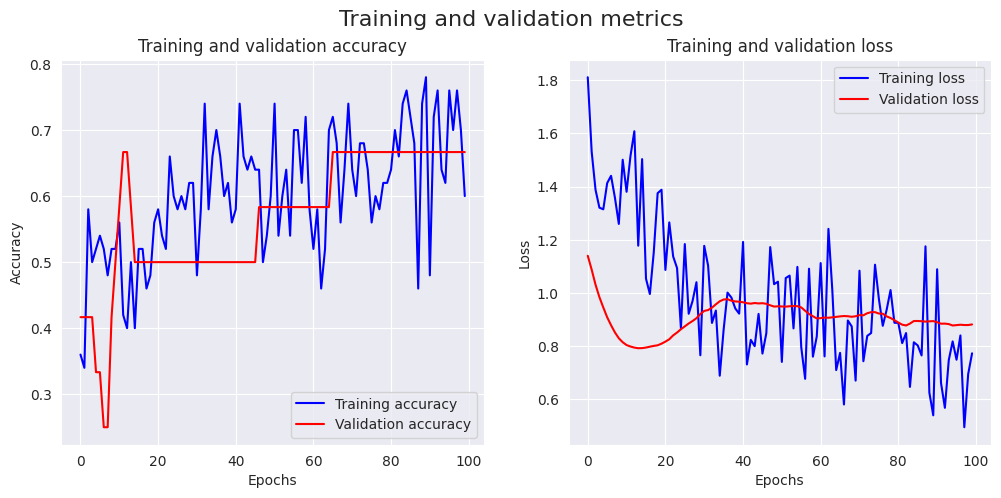

In [26]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

# 🔮Making predictions on the Test Data

In [27]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

1/1 [==============================] - 7s 7s/step
The first 5 predictions: ['nonvm', 'vm', 'nonvm', 'nonvm', 'nonvm']


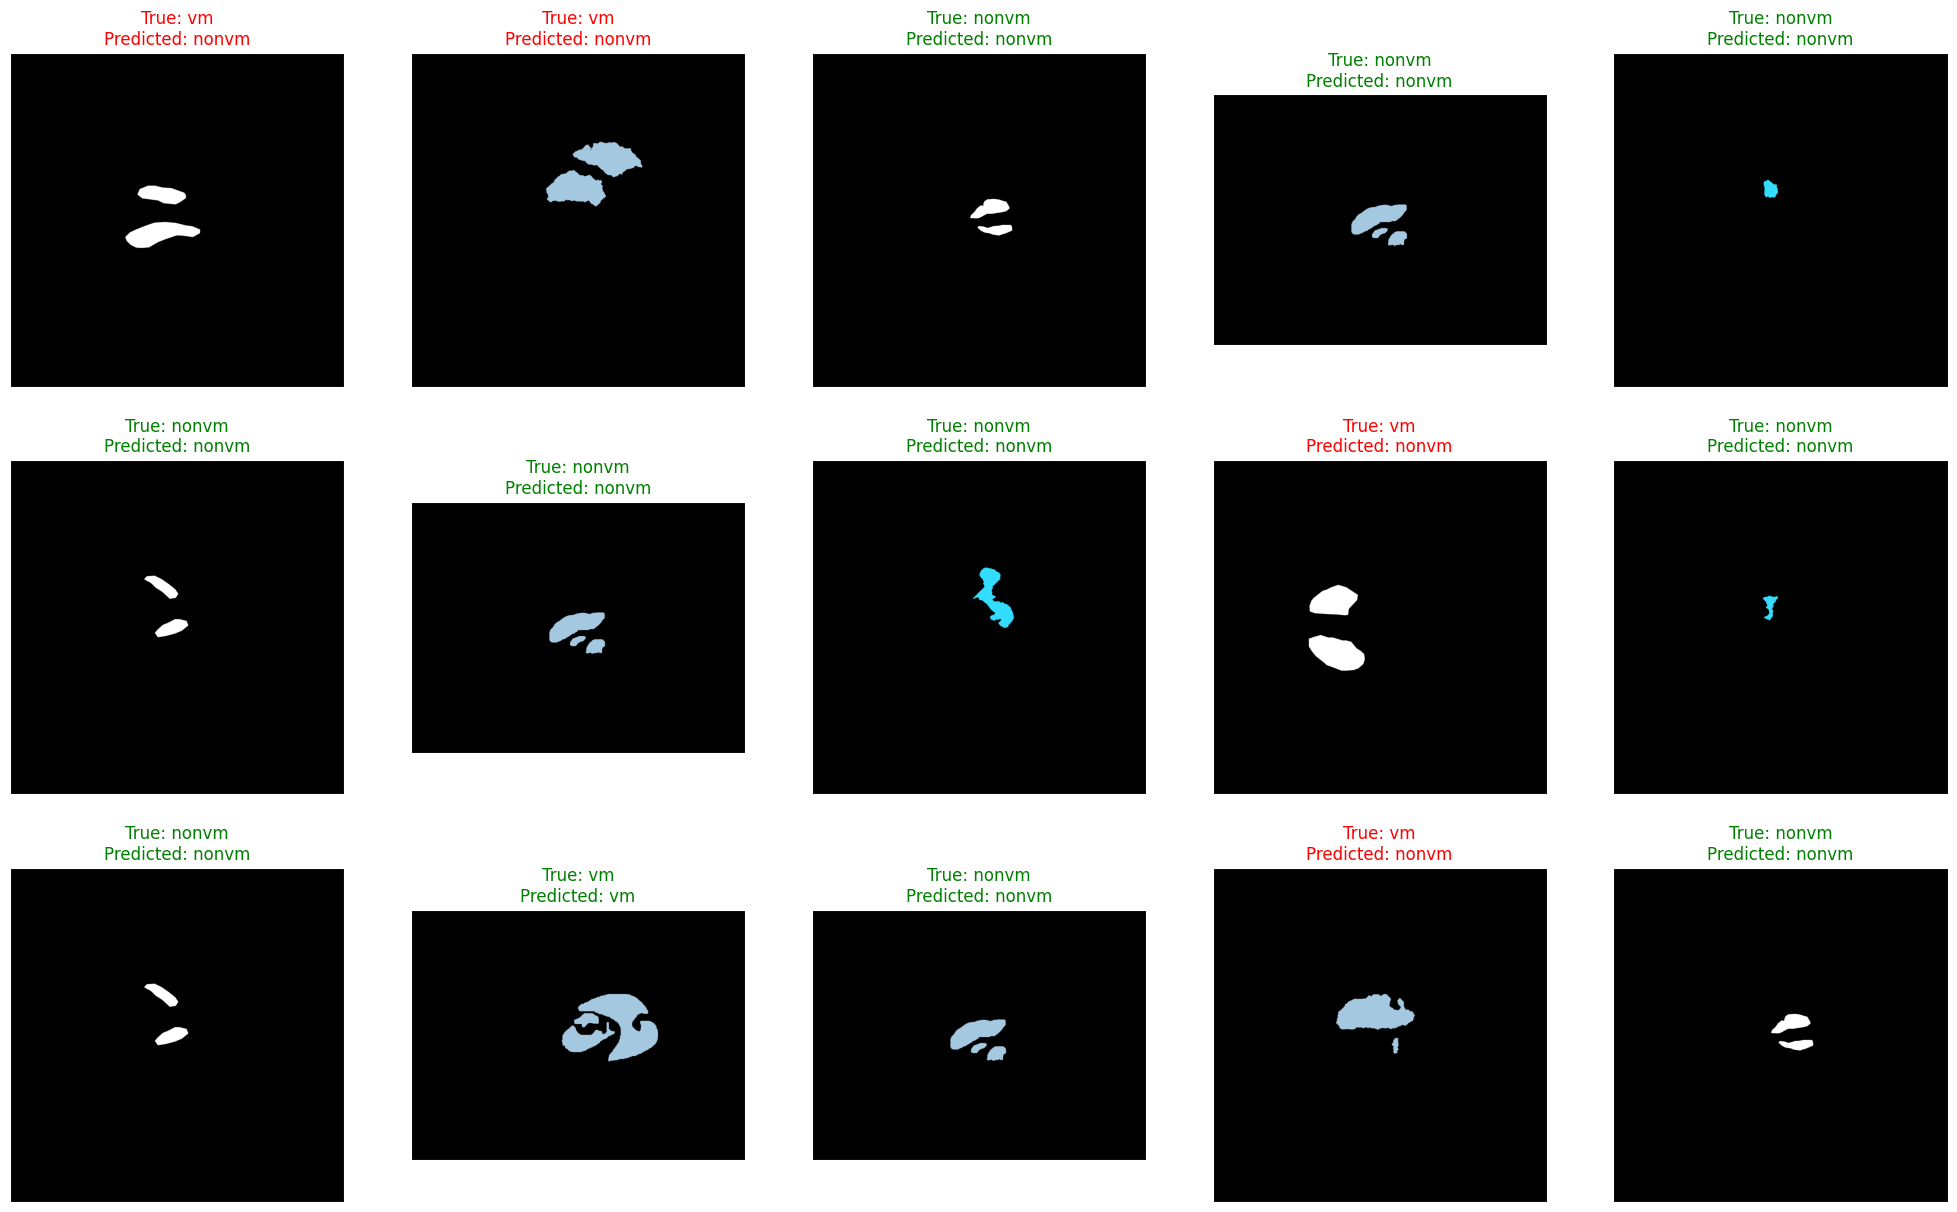

<Figure size 640x480 with 0 Axes>

In [28]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [29]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

/tmp/ipykernel_87/3614164838.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


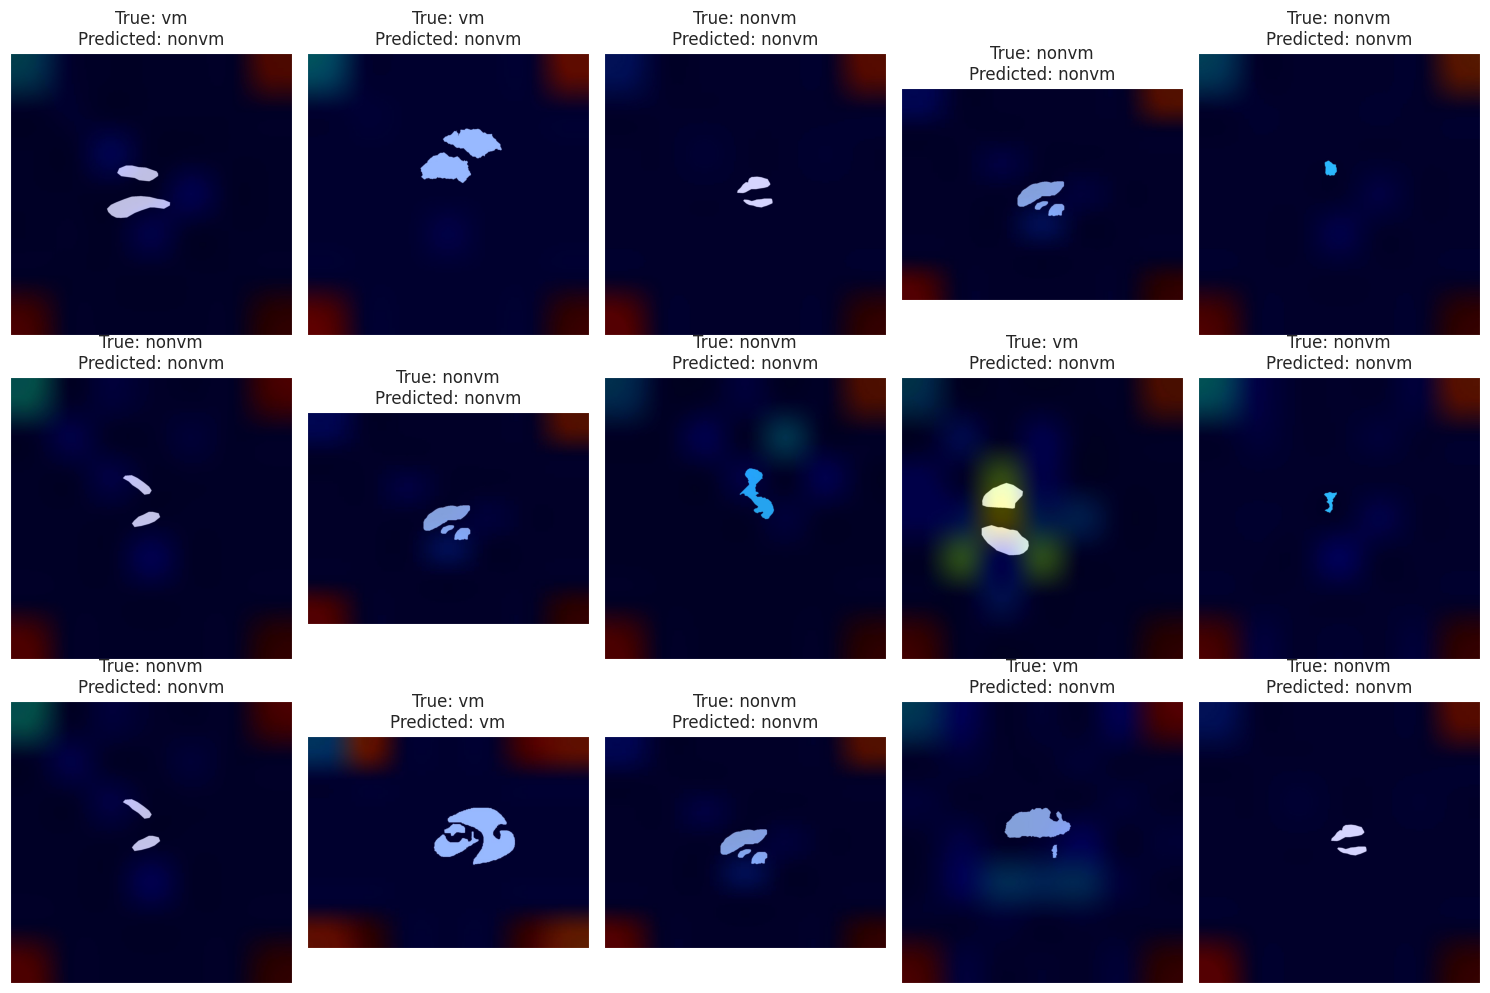

In [30]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


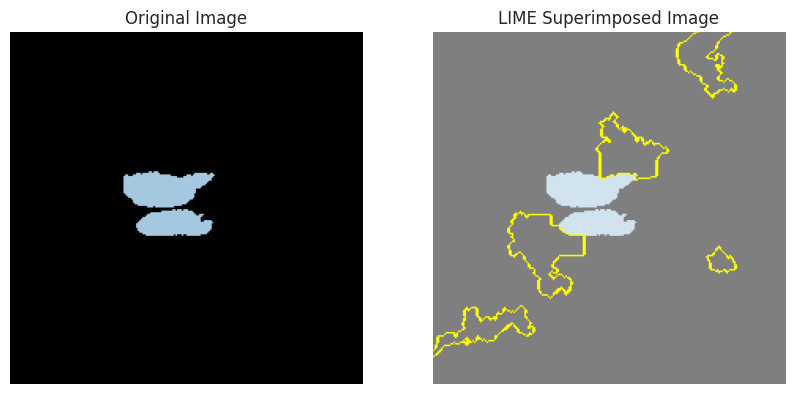

In [34]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries
# Assuming make_gradcam_heatmap and save_and_display_gradcam functions are defined somewhere in your code

# Load EfficientNetB0 model


# Function to apply LIME to a sample image
def apply_lime(model, img_path):
    explainer = lime_image.LimeImageExplainer()

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Resize to match VGG16 input size
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image data
    img_array = img_array.astype(np.double)  # Cast to double

    # Define the predict function for the model
    def predict_function(images):
        preds = model.predict(images)
        return preds

    # Explain the instance
    explanation = explainer.explain_instance(img_array, predict_function, top_labels=1, hide_color=0, num_samples=1000)

    # Get processed image
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # Create superimposed image
    superimposed_img = mark_boundaries(temp / 2 + 0.5, mask)
    return superimposed_img

# Apply LIME to a sample image from the test set
sample_img_path = "/kaggle/input/vm-7-2-1-split/Final/train_set/vm/mask_16.png"
lime_img = apply_lime(model, sample_img_path)

# Display the original image and the LIME superimposed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tf.keras.preprocessing.image.load_img(sample_img_path, target_size=(224, 224)))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lime_img)
plt.title('LIME Superimposed Image')
plt.axis('off')

plt.show()


In [36]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf


In [37]:
image_dir = "/kaggle/input/vm-7-2-1-split/Final/train_set/vm"

# List to store images and labels
images = []
labels = []

# Iterate over the images in the directory
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the image
        img = Image.open(os.path.join(image_dir, filename))
        # Preprocess the image (resize and apply preprocessing)
        img = img.resize((224, 224))  # Resize the image if needed
        img_array = np.array(img)
        img_array = preprocess_input(img_array)
        # Append the preprocessed image to the list of images
        images.append(img_array)
        # Extract the label from the filename (you'll need to customize this based on your filename format)
        label = filename.split("_")[0]  # Assuming the label is the first part of the filename before underscore
        labels.append(label)

# Convert the lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Print the shape of the arrays
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)

Shape of X (images): (36, 224, 224, 3)
Shape of y (labels): (36,)


In [38]:
import shap

# Define a function to preprocess the input image and pass it through the model
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# Define the masker
masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

# Create the explainer
explainer_blur = shap.Explainer(f, masker_blur)

# Explain the SHAP values for the images
shap_values_fine = explainer_blur(
    X[1:6], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:2]  # Changed to 2 classes
)


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [00:31<00:14,  7.40s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [00:46<00:10, 10.52s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [01:01<00:00, 12.15s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [01:16, 15.29s/it]                       


In [39]:
print(shap_values_fine.shape)

(5, 224, 224, 3, 2)


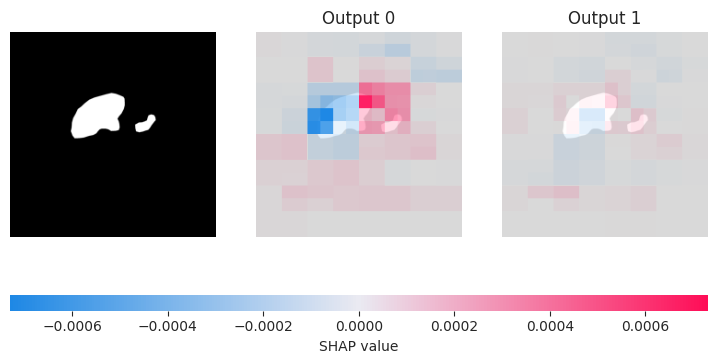

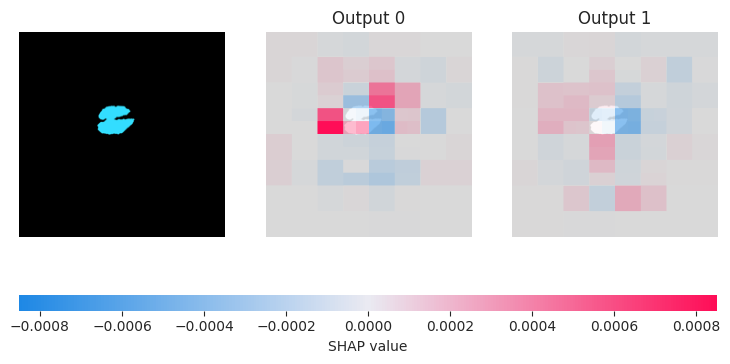

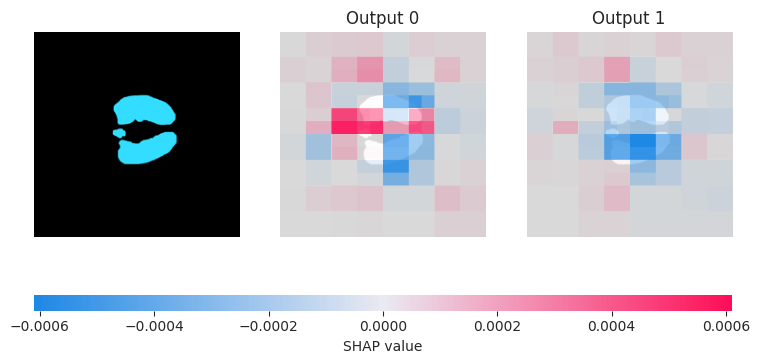

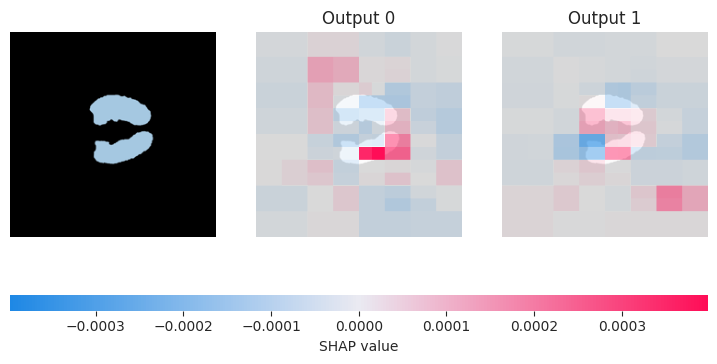

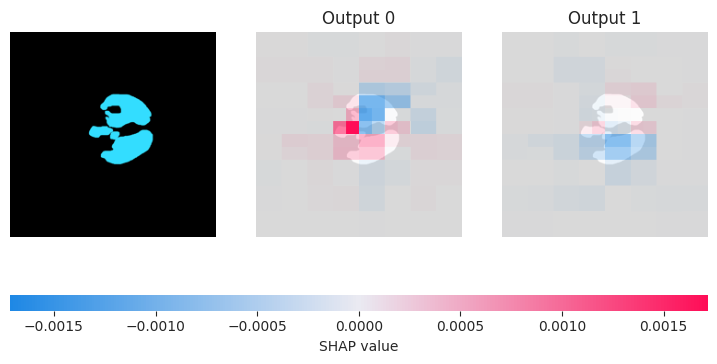

In [40]:
# Plot SHAP values for the first image and the first output class
for i in range(shap_values_fine.shape[0]):
        # Plot SHAP values for the current sample and output class
        shap.image_plot(shap_values_fine[i])

